<a href="https://colab.research.google.com/github/12dylan3/LSTockMarket-Predictions/blob/main/Apple_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from functools import reduce
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Preprocess

In [58]:
def get_data(url):
    """
    read the stock data and split into train and test
    :param url: url to raw csv from github.
    :return: train_sequences, train_labels, and test_sequences, test_labels, and the scalar
    """
    # Done TODO: load training data from training file.
    test_ratio = 0.2
    sequence_length = 50
    
    data = pd.read_csv(url)
    data = data.drop(['Date','Adj Close'], axis=1)

    num_data_points = data.shape[0]
    split_index = math.floor(num_data_points*(1-test_ratio))

    train_data = data[:split_index]
    test_data = data[split_index-sequence_length:]

    #Why do this? This turns everything into [0,1]
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    train_sequences = []
    train_labels = []
    for i in range(sequence_length, train_data.shape[0]):
      train_sequences.append(train_data[i-sequence_length:i])
      train_labels.append(train_data[i, 0])
    
    test_sequences = []
    test_labels = []
    for i in range(sequence_length, test_data.shape[0]):
      test_sequences.append(test_data[i-sequence_length:i])
      test_labels.append(test_data[i, 0])

                     
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)

    return (train_sequences, train_labels, test_sequences, test_labels, scaler)

Model Class

In [57]:
class Model(tf.keras.Model):
    def __init__(self):
        """
        The Model class predicts the next day's opening stock price given a sequence of previous days.

        """

        super(Model, self).__init__()

        self.batch_size = 64
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
        self.RNN1 = tf.keras.layers.LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (60, 1))
        self.RNN2 = tf.keras.layers.LSTM(units = 80, activation = 'relu')
        self.Dense1 = tf.keras.layers.Dense(1)



    def call(self, train_sequences):
        """
        :param train_sequences: stock data for sequence_length day period of shape (batch_size, sequence_length, 1)
        :return: the scaled predicted opening price for the next (sequence_length + 1st) day  
        """
        output = self.RNN1(train_sequences)
        output = self.RNN2(output)
        output = self.Dense1(output)
        output = tf.convert_to_tensor(output)
        
        return output

    def loss(self, predictions, labels):
        """
        Calculates mean squared error loss of the prediction
        
        NOTE: You have to use np.reduce_mean and not np.reduce_sum when calculating your loss

        :param predictions: a matrix of shape (batch_size, 1) as a tensor
        :param labels: matrix of shape (batch_size, 1) containing the labels
        :return: the loss of the model as a tensor of size 1
        """

        loss = tf.keras.losses.mean_squared_error(labels, predictions)
        loss = tf.reduce_mean(loss)

        return loss

Train and Results

In [28]:
def train(model, train_sequences, train_labels):
    """
    Runs through one epoch - all training examples.

    :param model: the initilized model to use for forward and backward pass
    :param train_sequences: train inputs (all inputs for training) of shape (num_sequences, sequence_length, 1)
    :param train_labels: train labels (all labels for training) of shape (num_sequences, 1)
    :return: None
    """
    #TODO: Fill in

    i = 0
    count = 0
    while i < len(train_sequences)-model.batch_size:
        print("Batch number: " + str(count))
        batch_inputs = train_sequences[i:i+model.batch_size]
        print(np.shape(batch_inputs))
        batch_labels = train_labels[i:i+model.batch_size]


        with tf.GradientTape() as tape:
            call_return = model.call(batch_inputs)
            loss = model.loss(call_return, batch_labels)

        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        i += model.batch_size
        count += 1

    pass


def plot(model, test_sequences, test_labels, scale_array):
    """
    Runs through one epoch - all testing examples

    :param model: the trained model to use for prediction
    :param test_sequences: test inputs (all inputs for testing) of shape (num_sequences, sequence_length, 1)
    :param test_labels: train labels (all labels for testing) of shape (num_sequences,)
    :param scale_array: min max scalar used to scale data
    """
    predictions = model.call(test_sequences)
    predictions = np.squeeze(predictions, 1)

    #Scaling back up to actual stock prices
    scale = 1/scale_array[0]
    predictions = predictions*scale
    test_labels = test_labels*scale

    errors = np.subtract(test_labels, predictions)
    errors = np.absolute(errors)
    errors = np.divide(errors, test_labels)
    error = np.mean(errors)
    error = error*100
    print("Mean absolute percentage error = " + str(error))
    
    # Plotting code adapted from Aarya Tadvalkar
    # https://kgptalkie.com/google-stock-price-prediction-using-rnn-lstm/
    plt.figure(figsize=(14,5))
    plt.plot(test_labels, color = 'red', label = 'Real Apple Stock Price')
    plt.plot(predictions, color = 'blue', label = 'Predicted Apple Stock Price')
    plt.title('Apple Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Apple Stock Price')
    plt.legend()
    plt.show()

    pass  

In [45]:
def main():
    apple_raw_url = url = 'https://raw.githubusercontent.com/12dylan3/LSTockMarket-Predictions/main/AAPL.csv'
    [train_sequences, train_labels, test_sequences, test_labels, scaler] = get_data(url)
    print(np.shape(train_sequences))
    print(np.shape(train_labels))
    print(np.shape(test_sequences))
    print(np.shape(test_labels))
    model = Model()
    
    for i in range(10):
      train(model, train_sequences, train_labels)
    plot(model, test_sequences, test_labels, scaler.scale_)



            Open
0      21.201786
1      20.778572
2      20.318214
3      18.890715
4      19.764286
...          ...
2010  115.550003
2011  116.570000
2012  116.970001
2013  121.010002
2014  122.019997

[2015 rows x 1 columns]
(1562, 50, 1)
(1562,)
(403, 50, 1)
(403,)
In Train
Batch number: 0
(64, 50, 1)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Batch number: 1
(64, 50, 1)
Batch number: 2
(64, 50, 1)
Batch number: 3
(64, 50, 1)
Batch number: 4
(64, 50, 1)
Batch number: 5
(64, 50, 1)
Batch number: 6
(64, 50, 1)
Batch number: 7
(64, 50, 1)
Batc

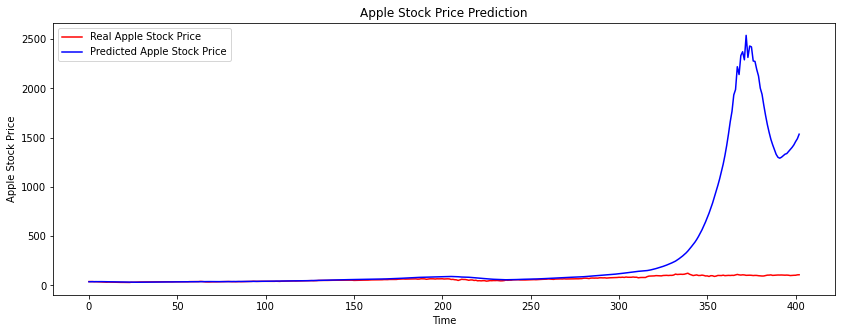

In [61]:
main()

